[View in Colaboratory](https://colab.research.google.com/github/redcican/Master-Thesis/blob/master/07_2_Compare_L2_Regularization_Binary_Classification_Diabetes.ipynb)

# Compare the $L_2 $ Regularization on a  Binary Classification Task using Diabetes Datasets

## Data Visualization and Preprocessing

In [1]:
!wget https://raw.githubusercontent.com/redcican/Master-Thesis/master/Diabetes.csv

--2018-06-19 08:05:29--  https://raw.githubusercontent.com/redcican/Master-Thesis/master/Diabetes.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1268166 (1.2M) [text/plain]
Saving to: ‘Diabetes.csv.1’

Diabetes.csv.1      100%[===================>]   1.21M  --.-KB/s    in 0.04s   

2018-06-19 08:05:29 (33.9 MB/s) - ‘Diabetes.csv.1’ saved [1268166/1268166]



In [0]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

In [0]:
from keras.models import Sequential
from keras import regularizers
from keras.layers import Dense, regularizers, Activation, LeakyReLU, PReLU
from keras.utils.vis_utils import plot_model
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import classification_report,roc_curve,auc, confusion_matrix
from keras.utils import to_categorical

In [4]:
rawdf = pd.read_csv('Diabetes.csv')
rawdf.head()

,PatientID,Pregnancies,PlasmaGlucose,DiastolicBloodPressure,TricepsThickness,SerumInsulin,BMI,DiabetesPedigree,Age,Diabetic,Physician,Ln(Age)
0,1354778,0,171,80,34,23,43.509726,1.213191,21,0,Dan Drayton,3.044522
1,1147438,8,92,93,47,36,21.240576,0.158365,23,0,Anthony Frizzell,3.135494
2,1640031,7,115,47,52,35,41.511523,0.079019,23,0,Gordon Fredrickson,3.135494
3,1883350,9,103,78,25,304,29.582192,1.282870,43,1,Chad Corbitt,3.761200
4,1424119,1,85,59,27,35,42.604536,0.549542,22,0,Zachary Fellows,3.091042


In [0]:
df = rawdf.copy()

#feature scale
ss = StandardScaler()
scale_features = ['PlasmaGlucose','DiastolicBloodPressure','TricepsThickness','SerumInsulin','BMI']
                  
df[scale_features] = ss.fit_transform(df[scale_features])

In [0]:
minmax = MinMaxScaler()
minmax_features = ['Pregnancies','DiabetesPedigree','Age','Ln(Age)']
df[minmax_features] = minmax.fit_transform(df[minmax_features])

In [7]:
df.head()

,PatientID,Pregnancies,PlasmaGlucose,DiastolicBloodPressure,TricepsThickness,SerumInsulin,BMI,DiabetesPedigree,Age,Diabetic,Physician,Ln(Age)
0,1354778,0.000000,1.974401,0.523884,0.356298,-0.863136,1.229683,0.510511,0.000000,0,Dan Drayton,0.000000
1,1147438,0.571429,-0.495823,1.299626,1.249448,-0.765438,-1.052302,0.036123,0.035714,0,Anthony Frizzell,0.070017
2,1640031,0.500000,0.223356,-1.445306,1.592967,-0.772953,1.024922,0.000438,0.035714,0,Gordon Fredrickson,0.070017
3,1883350,0.642857,-0.151868,0.404539,-0.262036,1.248633,-0.197512,0.541848,0.392857,1,Chad Corbitt,0.551595
4,1424119,0.071429,-0.714703,-0.729237,-0.124629,-0.772953,1.136926,0.212047,0.017857,0,Zachary Fellows,0.035804


In [27]:
X = df.drop(['PatientID','Physician','Diabetic'],axis=1).values
y = (df['Diabetic'].values).reshape(-1,1)
y = to_categorical(y,2)
X_train,X_test, Y_train,Y_test = train_test_split(X, y, test_size=0.2, random_state=0)
print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)

(12000, 9) (12000, 2) (3000, 9) (3000, 2)


In [0]:
# For keras
def plot_confusion_matrix(model, X, Y):
  y_pred = model.predict_classes(X, verbose=0)
  plt.figure(figsize=(8,6))
  sns.heatmap(pd.DataFrame(confusion_matrix(Y, y_pred)), annot=True, fmt='d', cmap='YlGnBu',alpha=0.8,vmin=0)
  

## 1 .Deep Neural Networks for Classification using different loss Functions

In [0]:
batch_size = 256
epochs = 200

In [0]:
def model(regularizer):
  model = Sequential()
  model.add(Dense(32, input_shape=(X.shape[1],), activation='relu',kernel_regularizer=regularizer))
  model.add(Dense(64, activation='relu',kernel_regularizer=regularizer))
  model.add(Dense(64, activation='relu',kernel_regularizer=regularizer))
  model.add(Dense(32, activation='relu',kernel_regularizer=regularizer))
  model.add(Dense(8, activation='relu',kernel_regularizer=regularizer))
  model.add(Dense(2, activation='softmax',kernel_regularizer=regularizer))
  model.compile('adam','binary_crossentropy',metrics=['accuracy'])
  
  return model

### 1.1   Neural Network without Regularization

In [49]:
regu_1 = None
model_1 = model(regu_1)
model_1.history = model_1.fit(X_train,Y_train,
                              epochs=epochs,
                              batch_size=batch_size,
                              validation_data=(X_test,Y_test),verbose=2)

Train on 12000 samples, validate on 3000 samples
Epoch 1/200
 - 1s - loss: 0.5301 - acc: 0.7417 - val_loss: 0.4413 - val_acc: 0.7993
Epoch 2/200
 - 0s - loss: 0.4173 - acc: 0.8066 - val_loss: 0.3975 - val_acc: 0.8233
Epoch 3/200
 - 0s - loss: 0.3921 - acc: 0.8197 - val_loss: 0.3842 - val_acc: 0.8267
Epoch 4/200
 - 0s - loss: 0.3759 - acc: 0.8294 - val_loss: 0.3711 - val_acc: 0.8380
Epoch 5/200
 - 0s - loss: 0.3640 - acc: 0.8371 - val_loss: 0.3624 - val_acc: 0.8383
Epoch 6/200
 - 0s - loss: 0.3535 - acc: 0.8405 - val_loss: 0.3586 - val_acc: 0.8393
Epoch 7/200
 - 0s - loss: 0.3430 - acc: 0.8483 - val_loss: 0.3519 - val_acc: 0.8473
Epoch 8/200
 - 0s - loss: 0.3362 - acc: 0.8504 - val_loss: 0.3439 - val_acc: 0.8463
Epoch 9/200
 - 0s - loss: 0.3226 - acc: 0.8578 - val_loss: 0.3323 - val_acc: 0.8573
Epoch 10/200
 - 0s - loss: 0.3129 - acc: 0.8632 - val_loss: 0.3315 - val_acc: 0.8583
Epoch 11/200
 - 0s - loss: 0.3023 - acc: 0.8696 - val_loss: 0.3123 - val_acc: 0.8667
Epoch 12/200
 - 0s - loss

 - 0s - loss: 0.2012 - acc: 0.9133 - val_loss: 0.2803 - val_acc: 0.8890
Epoch 35/200
 - 0s - loss: 0.2008 - acc: 0.9152 - val_loss: 0.2573 - val_acc: 0.8947
Epoch 36/200
 - 0s - loss: 0.1949 - acc: 0.9192 - val_loss: 0.2615 - val_acc: 0.8983
Epoch 37/200
 - 0s - loss: 0.1899 - acc: 0.9203 - val_loss: 0.2614 - val_acc: 0.8933
Epoch 38/200
 - 0s - loss: 0.1937 - acc: 0.9218 - val_loss: 0.2610 - val_acc: 0.8940
Epoch 39/200
 - 0s - loss: 0.1890 - acc: 0.9202 - val_loss: 0.2608 - val_acc: 0.8953
Epoch 40/200
 - 0s - loss: 0.1875 - acc: 0.9236 - val_loss: 0.2620 - val_acc: 0.8933
Epoch 41/200
 - 0s - loss: 0.1897 - acc: 0.9211 - val_loss: 0.2596 - val_acc: 0.8930
Epoch 42/200
 - 0s - loss: 0.1866 - acc: 0.9226 - val_loss: 0.2684 - val_acc: 0.8947
Epoch 43/200
 - 0s - loss: 0.1868 - acc: 0.9228 - val_loss: 0.2715 - val_acc: 0.8897
Epoch 44/200
 - 0s - loss: 0.1844 - acc: 0.9243 - val_loss: 0.2619 - val_acc: 0.8963
Epoch 45/200
 - 0s - loss: 0.1836 - acc: 0.9248 - val_loss: 0.2689 - val_acc: 

Epoch 68/200
 - 0s - loss: 0.1581 - acc: 0.9363 - val_loss: 0.2785 - val_acc: 0.8897
Epoch 69/200
 - 0s - loss: 0.1589 - acc: 0.9358 - val_loss: 0.2746 - val_acc: 0.8920
Epoch 70/200
 - 0s - loss: 0.1530 - acc: 0.9391 - val_loss: 0.2809 - val_acc: 0.8970
Epoch 71/200
 - 0s - loss: 0.1559 - acc: 0.9371 - val_loss: 0.2847 - val_acc: 0.8973
Epoch 72/200
 - 0s - loss: 0.1536 - acc: 0.9389 - val_loss: 0.3003 - val_acc: 0.8937
Epoch 73/200
 - 0s - loss: 0.1544 - acc: 0.9382 - val_loss: 0.2765 - val_acc: 0.8947
Epoch 74/200
 - 0s - loss: 0.1551 - acc: 0.9360 - val_loss: 0.2847 - val_acc: 0.8917
Epoch 75/200
 - 0s - loss: 0.1531 - acc: 0.9358 - val_loss: 0.2786 - val_acc: 0.8960
Epoch 76/200
 - 0s - loss: 0.1560 - acc: 0.9338 - val_loss: 0.2889 - val_acc: 0.8950
Epoch 77/200
 - 0s - loss: 0.1516 - acc: 0.9380 - val_loss: 0.2866 - val_acc: 0.8963
Epoch 78/200
 - 0s - loss: 0.1483 - acc: 0.9417 - val_loss: 0.2818 - val_acc: 0.8943
Epoch 79/200
 - 0s - loss: 0.1466 - acc: 0.9410 - val_loss: 0.297

Epoch 102/200
 - 0s - loss: 0.1309 - acc: 0.9455 - val_loss: 0.3246 - val_acc: 0.8900
Epoch 103/200
 - 0s - loss: 0.1264 - acc: 0.9493 - val_loss: 0.3182 - val_acc: 0.8887
Epoch 104/200
 - 0s - loss: 0.1270 - acc: 0.9492 - val_loss: 0.3125 - val_acc: 0.8917
Epoch 105/200
 - 0s - loss: 0.1298 - acc: 0.9467 - val_loss: 0.3138 - val_acc: 0.8890
Epoch 106/200
 - 0s - loss: 0.1280 - acc: 0.9475 - val_loss: 0.3246 - val_acc: 0.8850
Epoch 107/200
 - 0s - loss: 0.1270 - acc: 0.9492 - val_loss: 0.3125 - val_acc: 0.8930
Epoch 108/200
 - 0s - loss: 0.1260 - acc: 0.9495 - val_loss: 0.3198 - val_acc: 0.8927
Epoch 109/200
 - 0s - loss: 0.1208 - acc: 0.9520 - val_loss: 0.3268 - val_acc: 0.8933
Epoch 110/200
 - 0s - loss: 0.1292 - acc: 0.9479 - val_loss: 0.3256 - val_acc: 0.8900
Epoch 111/200
 - 0s - loss: 0.1206 - acc: 0.9518 - val_loss: 0.3174 - val_acc: 0.8907
Epoch 112/200
 - 0s - loss: 0.1205 - acc: 0.9516 - val_loss: 0.3280 - val_acc: 0.8863
Epoch 113/200
 - 0s - loss: 0.1227 - acc: 0.9507 - val

Epoch 136/200
 - 0s - loss: 0.1045 - acc: 0.9571 - val_loss: 0.3633 - val_acc: 0.8883
Epoch 137/200
 - 0s - loss: 0.1118 - acc: 0.9558 - val_loss: 0.3586 - val_acc: 0.8867
Epoch 138/200
 - 0s - loss: 0.1007 - acc: 0.9603 - val_loss: 0.3727 - val_acc: 0.8843
Epoch 139/200
 - 0s - loss: 0.1040 - acc: 0.9581 - val_loss: 0.3688 - val_acc: 0.8867
Epoch 140/200
 - 0s - loss: 0.1032 - acc: 0.9583 - val_loss: 0.3652 - val_acc: 0.8860
Epoch 141/200
 - 0s - loss: 0.0957 - acc: 0.9622 - val_loss: 0.4025 - val_acc: 0.8793
Epoch 142/200
 - 0s - loss: 0.1000 - acc: 0.9607 - val_loss: 0.3851 - val_acc: 0.8900
Epoch 143/200
 - 0s - loss: 0.0979 - acc: 0.9602 - val_loss: 0.3830 - val_acc: 0.8910
Epoch 144/200
 - 0s - loss: 0.0948 - acc: 0.9638 - val_loss: 0.3936 - val_acc: 0.8877
Epoch 145/200
 - 0s - loss: 0.0959 - acc: 0.9608 - val_loss: 0.3871 - val_acc: 0.8843
Epoch 146/200
 - 0s - loss: 0.0963 - acc: 0.9616 - val_loss: 0.3890 - val_acc: 0.8937
Epoch 147/200
 - 0s - loss: 0.0948 - acc: 0.9612 - val

Epoch 170/200
 - 0s - loss: 0.0840 - acc: 0.9672 - val_loss: 0.4455 - val_acc: 0.8853
Epoch 171/200
 - 0s - loss: 0.0809 - acc: 0.9685 - val_loss: 0.4475 - val_acc: 0.8833
Epoch 172/200
 - 0s - loss: 0.0803 - acc: 0.9672 - val_loss: 0.4661 - val_acc: 0.8757
Epoch 173/200
 - 0s - loss: 0.0781 - acc: 0.9708 - val_loss: 0.4673 - val_acc: 0.8830
Epoch 174/200
 - 0s - loss: 0.0824 - acc: 0.9678 - val_loss: 0.4507 - val_acc: 0.8813
Epoch 175/200
 - 0s - loss: 0.0728 - acc: 0.9718 - val_loss: 0.4453 - val_acc: 0.8873
Epoch 176/200
 - 0s - loss: 0.0778 - acc: 0.9707 - val_loss: 0.4530 - val_acc: 0.8843
Epoch 177/200
 - 0s - loss: 0.0793 - acc: 0.9693 - val_loss: 0.4712 - val_acc: 0.8880
Epoch 178/200
 - 0s - loss: 0.0719 - acc: 0.9741 - val_loss: 0.4606 - val_acc: 0.8833
Epoch 179/200
 - 0s - loss: 0.0693 - acc: 0.9738 - val_loss: 0.4769 - val_acc: 0.8830
Epoch 180/200
 - 0s - loss: 0.0728 - acc: 0.9734 - val_loss: 0.4671 - val_acc: 0.8800
Epoch 181/200
 - 0s - loss: 0.0684 - acc: 0.9747 - val

             precision    recall  f1-score   support

          0       0.92      0.90      0.91      2002
          1       0.81      0.85      0.83       998

avg / total       0.89      0.88      0.88      3000



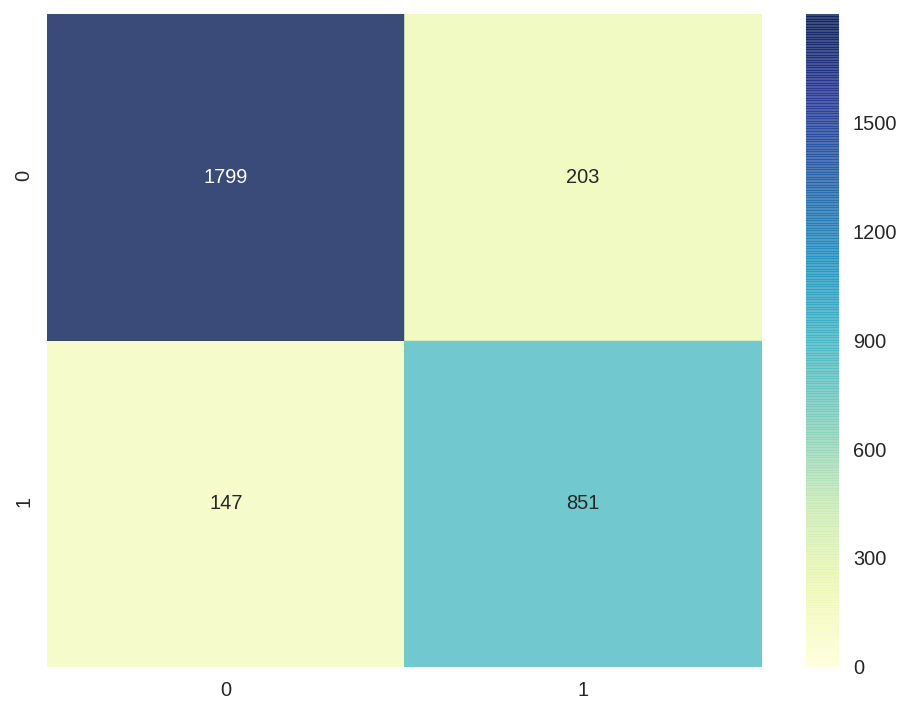

In [50]:
y_pred_1 = model_1.predict_classes(X_test,verbose=0)
y_test_class_1 = np.argmax(Y_test,axis=1)
print(classification_report(y_test_class_1,y_pred_1))
plot_confusion_matrix(model_1,X_test,y_test_class_1)

In [51]:
train_loss_1, train_accuracy_1 = model_1.evaluate(X_train, Y_train, verbose=0)
print("Training Accuracy = %.2f %%     loss = %f" % (train_accuracy_1 * 100, train_loss_1))
test_loss_1, test_accuracy_1 = model_1.evaluate(X_test, Y_test, verbose=0)
print("Testing Accuracy = %.2f %%    loss = %f" % (test_accuracy_1 * 100, test_loss_1))

Training Accuracy = 98.17 %     loss = 0.052574
Testing Accuracy = 88.33 %    loss = 0.540209


### 1.2 Neural Network with L2 Regularization $\lambda=0.1$

In [52]:
regu_2 = regularizers.l2(l=0.1)
model_2 = model(regu_2)
model_2.history = model_2.fit(X_train,Y_train,
                              epochs=epochs,
                              batch_size=batch_size,
                              validation_data=(X_test,Y_test),verbose=2)

Train on 12000 samples, validate on 3000 samples
Epoch 1/200
 - 1s - loss: 14.6610 - acc: 0.6428 - val_loss: 10.8261 - val_acc: 0.6673
Epoch 2/200
 - 0s - loss: 8.3328 - acc: 0.6665 - val_loss: 6.1861 - val_acc: 0.6673
Epoch 3/200
 - 0s - loss: 4.8166 - acc: 0.6665 - val_loss: 3.6415 - val_acc: 0.6673
Epoch 4/200
 - 0s - loss: 2.8994 - acc: 0.6665 - val_loss: 2.2660 - val_acc: 0.6673
Epoch 5/200
 - 0s - loss: 1.8706 - acc: 0.6665 - val_loss: 1.5340 - val_acc: 0.6673
Epoch 6/200
 - 0s - loss: 1.3249 - acc: 0.6665 - val_loss: 1.1465 - val_acc: 0.6673
Epoch 7/200
 - 0s - loss: 1.0358 - acc: 0.6665 - val_loss: 0.9403 - val_acc: 0.6673
Epoch 8/200
 - 0s - loss: 0.8803 - acc: 0.6665 - val_loss: 0.8273 - val_acc: 0.6673
Epoch 9/200
 - 0s - loss: 0.7935 - acc: 0.6665 - val_loss: 0.7626 - val_acc: 0.6673
Epoch 10/200
 - 0s - loss: 0.7427 - acc: 0.6665 - val_loss: 0.7236 - val_acc: 0.6673
Epoch 11/200
 - 0s - loss: 0.7111 - acc: 0.6665 - val_loss: 0.6987 - val_acc: 0.6673
Epoch 12/200
 - 0s - lo

 - 0s - loss: 0.6367 - acc: 0.6665 - val_loss: 0.6361 - val_acc: 0.6673
Epoch 35/200
 - 0s - loss: 0.6367 - acc: 0.6665 - val_loss: 0.6361 - val_acc: 0.6673
Epoch 36/200
 - 0s - loss: 0.6367 - acc: 0.6665 - val_loss: 0.6361 - val_acc: 0.6673
Epoch 37/200
 - 0s - loss: 0.6367 - acc: 0.6665 - val_loss: 0.6361 - val_acc: 0.6673
Epoch 38/200
 - 0s - loss: 0.6367 - acc: 0.6665 - val_loss: 0.6361 - val_acc: 0.6673
Epoch 39/200
 - 0s - loss: 0.6367 - acc: 0.6665 - val_loss: 0.6361 - val_acc: 0.6673
Epoch 40/200
 - 0s - loss: 0.6367 - acc: 0.6665 - val_loss: 0.6361 - val_acc: 0.6673
Epoch 41/200
 - 0s - loss: 0.6366 - acc: 0.6665 - val_loss: 0.6361 - val_acc: 0.6673
Epoch 42/200
 - 0s - loss: 0.6366 - acc: 0.6665 - val_loss: 0.6361 - val_acc: 0.6673
Epoch 43/200
 - 0s - loss: 0.6366 - acc: 0.6665 - val_loss: 0.6361 - val_acc: 0.6673
Epoch 44/200
 - 0s - loss: 0.6367 - acc: 0.6665 - val_loss: 0.6361 - val_acc: 0.6673
Epoch 45/200
 - 0s - loss: 0.6367 - acc: 0.6665 - val_loss: 0.6361 - val_acc: 

Epoch 68/200
 - 0s - loss: 0.6366 - acc: 0.6665 - val_loss: 0.6361 - val_acc: 0.6673
Epoch 69/200
 - 0s - loss: 0.6367 - acc: 0.6665 - val_loss: 0.6361 - val_acc: 0.6673
Epoch 70/200
 - 0s - loss: 0.6367 - acc: 0.6665 - val_loss: 0.6361 - val_acc: 0.6673
Epoch 71/200
 - 0s - loss: 0.6367 - acc: 0.6665 - val_loss: 0.6361 - val_acc: 0.6673
Epoch 72/200
 - 0s - loss: 0.6367 - acc: 0.6665 - val_loss: 0.6361 - val_acc: 0.6673
Epoch 73/200
 - 0s - loss: 0.6367 - acc: 0.6665 - val_loss: 0.6361 - val_acc: 0.6673
Epoch 74/200
 - 0s - loss: 0.6367 - acc: 0.6665 - val_loss: 0.6361 - val_acc: 0.6673
Epoch 75/200
 - 0s - loss: 0.6367 - acc: 0.6665 - val_loss: 0.6361 - val_acc: 0.6673
Epoch 76/200
 - 0s - loss: 0.6367 - acc: 0.6665 - val_loss: 0.6361 - val_acc: 0.6673
Epoch 77/200
 - 0s - loss: 0.6367 - acc: 0.6665 - val_loss: 0.6361 - val_acc: 0.6673
Epoch 78/200
 - 0s - loss: 0.6366 - acc: 0.6665 - val_loss: 0.6361 - val_acc: 0.6673
Epoch 79/200
 - 0s - loss: 0.6367 - acc: 0.6665 - val_loss: 0.636

Epoch 102/200
 - 0s - loss: 0.6367 - acc: 0.6665 - val_loss: 0.6361 - val_acc: 0.6673
Epoch 103/200
 - 0s - loss: 0.6367 - acc: 0.6665 - val_loss: 0.6361 - val_acc: 0.6673
Epoch 104/200
 - 0s - loss: 0.6367 - acc: 0.6665 - val_loss: 0.6361 - val_acc: 0.6673
Epoch 105/200
 - 0s - loss: 0.6367 - acc: 0.6665 - val_loss: 0.6361 - val_acc: 0.6673
Epoch 106/200
 - 0s - loss: 0.6367 - acc: 0.6665 - val_loss: 0.6361 - val_acc: 0.6673
Epoch 107/200
 - 0s - loss: 0.6367 - acc: 0.6665 - val_loss: 0.6361 - val_acc: 0.6673
Epoch 108/200
 - 0s - loss: 0.6366 - acc: 0.6665 - val_loss: 0.6361 - val_acc: 0.6673
Epoch 109/200
 - 0s - loss: 0.6367 - acc: 0.6665 - val_loss: 0.6361 - val_acc: 0.6673
Epoch 110/200
 - 0s - loss: 0.6367 - acc: 0.6665 - val_loss: 0.6361 - val_acc: 0.6673
Epoch 111/200
 - 0s - loss: 0.6367 - acc: 0.6665 - val_loss: 0.6361 - val_acc: 0.6673
Epoch 112/200
 - 0s - loss: 0.6367 - acc: 0.6665 - val_loss: 0.6361 - val_acc: 0.6673
Epoch 113/200
 - 0s - loss: 0.6367 - acc: 0.6665 - val

Epoch 136/200
 - 0s - loss: 0.6366 - acc: 0.6665 - val_loss: 0.6361 - val_acc: 0.6673
Epoch 137/200
 - 0s - loss: 0.6367 - acc: 0.6665 - val_loss: 0.6361 - val_acc: 0.6673
Epoch 138/200
 - 0s - loss: 0.6366 - acc: 0.6665 - val_loss: 0.6361 - val_acc: 0.6673
Epoch 139/200
 - 0s - loss: 0.6366 - acc: 0.6665 - val_loss: 0.6361 - val_acc: 0.6673
Epoch 140/200
 - 0s - loss: 0.6366 - acc: 0.6665 - val_loss: 0.6361 - val_acc: 0.6673
Epoch 141/200
 - 0s - loss: 0.6366 - acc: 0.6665 - val_loss: 0.6361 - val_acc: 0.6673
Epoch 142/200
 - 0s - loss: 0.6366 - acc: 0.6665 - val_loss: 0.6361 - val_acc: 0.6673
Epoch 143/200
 - 0s - loss: 0.6367 - acc: 0.6665 - val_loss: 0.6361 - val_acc: 0.6673
Epoch 144/200
 - 0s - loss: 0.6367 - acc: 0.6665 - val_loss: 0.6361 - val_acc: 0.6673
Epoch 145/200
 - 0s - loss: 0.6366 - acc: 0.6665 - val_loss: 0.6361 - val_acc: 0.6673
Epoch 146/200
 - 0s - loss: 0.6367 - acc: 0.6665 - val_loss: 0.6361 - val_acc: 0.6673
Epoch 147/200
 - 0s - loss: 0.6367 - acc: 0.6665 - val

Epoch 170/200
 - 0s - loss: 0.6367 - acc: 0.6665 - val_loss: 0.6361 - val_acc: 0.6673
Epoch 171/200
 - 0s - loss: 0.6367 - acc: 0.6665 - val_loss: 0.6361 - val_acc: 0.6673
Epoch 172/200
 - 0s - loss: 0.6366 - acc: 0.6665 - val_loss: 0.6361 - val_acc: 0.6673
Epoch 173/200
 - 0s - loss: 0.6367 - acc: 0.6665 - val_loss: 0.6361 - val_acc: 0.6673
Epoch 174/200
 - 0s - loss: 0.6367 - acc: 0.6665 - val_loss: 0.6361 - val_acc: 0.6673
Epoch 175/200
 - 0s - loss: 0.6366 - acc: 0.6665 - val_loss: 0.6361 - val_acc: 0.6673
Epoch 176/200
 - 0s - loss: 0.6367 - acc: 0.6665 - val_loss: 0.6361 - val_acc: 0.6673
Epoch 177/200
 - 0s - loss: 0.6367 - acc: 0.6665 - val_loss: 0.6361 - val_acc: 0.6673
Epoch 178/200
 - 0s - loss: 0.6367 - acc: 0.6665 - val_loss: 0.6361 - val_acc: 0.6673
Epoch 179/200
 - 0s - loss: 0.6366 - acc: 0.6665 - val_loss: 0.6361 - val_acc: 0.6673
Epoch 180/200
 - 0s - loss: 0.6367 - acc: 0.6665 - val_loss: 0.6361 - val_acc: 0.6673
Epoch 181/200
 - 0s - loss: 0.6366 - acc: 0.6665 - val

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


             precision    recall  f1-score   support

          0       0.67      1.00      0.80      2002
          1       0.00      0.00      0.00       998

avg / total       0.45      0.67      0.53      3000



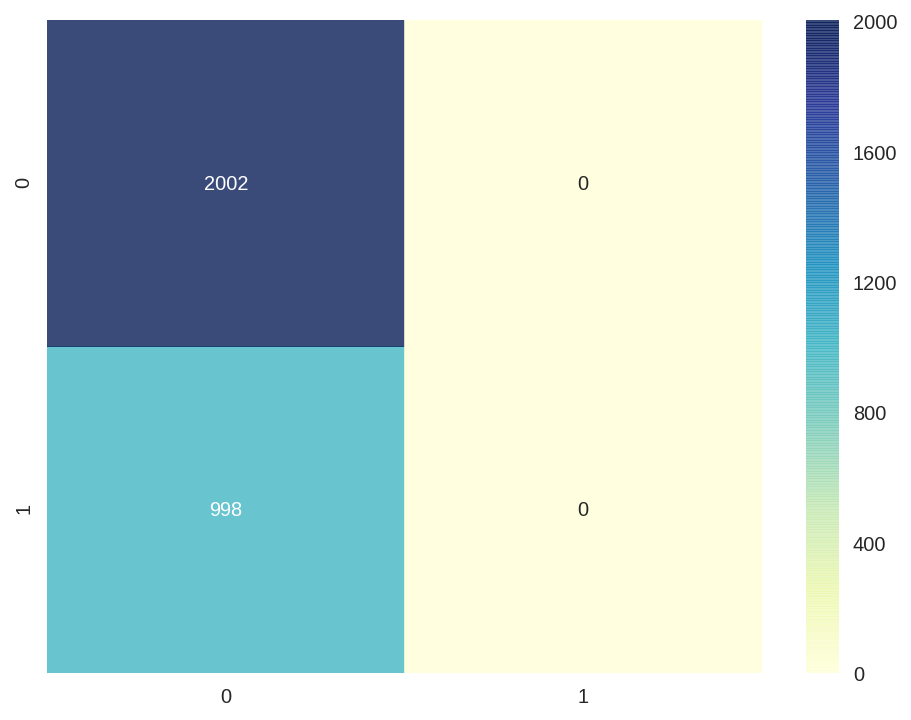

In [53]:
y_pred_2 = model_2.predict_classes(X_test,verbose=0)
y_test_class_2 = np.argmax(Y_test,axis=1)
print(classification_report(y_test_class_2,y_pred_2))
plot_confusion_matrix(model_2,X_test,y_test_class_2)

In [54]:
train_loss_2, train_accuracy_2 = model_2.evaluate(X_train, Y_train, verbose=0)
print("Training Accuracy = %.2f %%     loss = %f" % (train_accuracy_2 * 100, train_loss_2))
test_loss_2, test_accuracy_2 = model_2.evaluate(X_test, Y_test, verbose=0)
print("Testing Accuracy = %.2f %%    loss = %f" % (test_accuracy_2 * 100, test_loss_2))

Training Accuracy = 66.65 %     loss = 0.636633
Testing Accuracy = 66.73 %    loss = 0.636052


### 1.3 Neural Network with L2 Regularization $\lambda=0.01$

In [55]:
regu_3 = regularizers.l2(l=0.01)
model_3 = model(regu_3)
model_3.history = model_3.fit(X_train,Y_train,
                              epochs=epochs,
                              batch_size=batch_size,
                              validation_data=(X_test,Y_test),verbose=2)

Train on 12000 samples, validate on 3000 samples
Epoch 1/200
 - 1s - loss: 2.0722 - acc: 0.6426 - val_loss: 1.6693 - val_acc: 0.6673
Epoch 2/200
 - 0s - loss: 1.4080 - acc: 0.6665 - val_loss: 1.1752 - val_acc: 0.6673
Epoch 3/200
 - 0s - loss: 1.0295 - acc: 0.7108 - val_loss: 0.8948 - val_acc: 0.7597
Epoch 4/200
 - 0s - loss: 0.8150 - acc: 0.7749 - val_loss: 0.7368 - val_acc: 0.8010
Epoch 5/200
 - 0s - loss: 0.6941 - acc: 0.7934 - val_loss: 0.6471 - val_acc: 0.7983
Epoch 6/200
 - 0s - loss: 0.6227 - acc: 0.8074 - val_loss: 0.5929 - val_acc: 0.8180
Epoch 7/200
 - 0s - loss: 0.5788 - acc: 0.8145 - val_loss: 0.5589 - val_acc: 0.8223
Epoch 8/200
 - 0s - loss: 0.5507 - acc: 0.8200 - val_loss: 0.5376 - val_acc: 0.8257
Epoch 9/200
 - 0s - loss: 0.5330 - acc: 0.8232 - val_loss: 0.5238 - val_acc: 0.8313
Epoch 10/200
 - 0s - loss: 0.5228 - acc: 0.8272 - val_loss: 0.5157 - val_acc: 0.8293
Epoch 11/200
 - 0s - loss: 0.5166 - acc: 0.8273 - val_loss: 0.5082 - val_acc: 0.8353
Epoch 12/200
 - 0s - loss

 - 0s - loss: 0.4556 - acc: 0.8818 - val_loss: 0.4561 - val_acc: 0.8847
Epoch 35/200
 - 0s - loss: 0.4541 - acc: 0.8812 - val_loss: 0.4534 - val_acc: 0.8833
Epoch 36/200
 - 0s - loss: 0.4507 - acc: 0.8832 - val_loss: 0.4519 - val_acc: 0.8870
Epoch 37/200
 - 0s - loss: 0.4484 - acc: 0.8868 - val_loss: 0.4555 - val_acc: 0.8863
Epoch 38/200
 - 0s - loss: 0.4474 - acc: 0.8880 - val_loss: 0.4486 - val_acc: 0.8857
Epoch 39/200
 - 0s - loss: 0.4463 - acc: 0.8908 - val_loss: 0.4479 - val_acc: 0.8897
Epoch 40/200
 - 0s - loss: 0.4449 - acc: 0.8903 - val_loss: 0.4473 - val_acc: 0.8910
Epoch 41/200
 - 0s - loss: 0.4456 - acc: 0.8921 - val_loss: 0.4504 - val_acc: 0.8893
Epoch 42/200
 - 0s - loss: 0.4434 - acc: 0.8924 - val_loss: 0.4452 - val_acc: 0.8903
Epoch 43/200
 - 0s - loss: 0.4446 - acc: 0.8922 - val_loss: 0.4460 - val_acc: 0.8877
Epoch 44/200
 - 0s - loss: 0.4478 - acc: 0.8898 - val_loss: 0.4479 - val_acc: 0.8883
Epoch 45/200
 - 0s - loss: 0.4437 - acc: 0.8914 - val_loss: 0.4450 - val_acc: 

Epoch 68/200
 - 0s - loss: 0.4393 - acc: 0.8979 - val_loss: 0.4444 - val_acc: 0.8940
Epoch 69/200
 - 0s - loss: 0.4397 - acc: 0.8994 - val_loss: 0.4434 - val_acc: 0.8963
Epoch 70/200
 - 0s - loss: 0.4384 - acc: 0.8983 - val_loss: 0.4422 - val_acc: 0.8967
Epoch 71/200
 - 0s - loss: 0.4384 - acc: 0.8994 - val_loss: 0.4411 - val_acc: 0.8957
Epoch 72/200
 - 0s - loss: 0.4377 - acc: 0.8989 - val_loss: 0.4410 - val_acc: 0.8983
Epoch 73/200
 - 0s - loss: 0.4399 - acc: 0.8987 - val_loss: 0.4437 - val_acc: 0.8943
Epoch 74/200
 - 0s - loss: 0.4400 - acc: 0.8969 - val_loss: 0.4489 - val_acc: 0.8907
Epoch 75/200
 - 0s - loss: 0.4387 - acc: 0.8987 - val_loss: 0.4420 - val_acc: 0.8987
Epoch 76/200
 - 0s - loss: 0.4390 - acc: 0.8989 - val_loss: 0.4454 - val_acc: 0.8960
Epoch 77/200
 - 0s - loss: 0.4381 - acc: 0.8984 - val_loss: 0.4424 - val_acc: 0.8960
Epoch 78/200
 - 0s - loss: 0.4384 - acc: 0.8988 - val_loss: 0.4426 - val_acc: 0.8980
Epoch 79/200
 - 0s - loss: 0.4381 - acc: 0.9009 - val_loss: 0.443

Epoch 102/200
 - 0s - loss: 0.4377 - acc: 0.8991 - val_loss: 0.4416 - val_acc: 0.8960
Epoch 103/200
 - 0s - loss: 0.4374 - acc: 0.8986 - val_loss: 0.4444 - val_acc: 0.8940
Epoch 104/200
 - 0s - loss: 0.4374 - acc: 0.8989 - val_loss: 0.4406 - val_acc: 0.8977
Epoch 105/200
 - 0s - loss: 0.4368 - acc: 0.9015 - val_loss: 0.4441 - val_acc: 0.8987
Epoch 106/200
 - 0s - loss: 0.4374 - acc: 0.8984 - val_loss: 0.4434 - val_acc: 0.8923
Epoch 107/200
 - 0s - loss: 0.4368 - acc: 0.9022 - val_loss: 0.4468 - val_acc: 0.8983
Epoch 108/200
 - 0s - loss: 0.4373 - acc: 0.9002 - val_loss: 0.4434 - val_acc: 0.8987
Epoch 109/200
 - 0s - loss: 0.4376 - acc: 0.9009 - val_loss: 0.4447 - val_acc: 0.8957
Epoch 110/200
 - 0s - loss: 0.4385 - acc: 0.8991 - val_loss: 0.4431 - val_acc: 0.8990
Epoch 111/200
 - 0s - loss: 0.4373 - acc: 0.9013 - val_loss: 0.4438 - val_acc: 0.8930
Epoch 112/200
 - 0s - loss: 0.4359 - acc: 0.9012 - val_loss: 0.4443 - val_acc: 0.8973
Epoch 113/200
 - 0s - loss: 0.4391 - acc: 0.8987 - val

Epoch 136/200
 - 0s - loss: 0.4367 - acc: 0.9014 - val_loss: 0.4419 - val_acc: 0.8980
Epoch 137/200
 - 0s - loss: 0.4387 - acc: 0.8978 - val_loss: 0.4428 - val_acc: 0.8933
Epoch 138/200
 - 0s - loss: 0.4371 - acc: 0.8993 - val_loss: 0.4417 - val_acc: 0.8943
Epoch 139/200
 - 0s - loss: 0.4376 - acc: 0.8994 - val_loss: 0.4402 - val_acc: 0.8957
Epoch 140/200
 - 0s - loss: 0.4361 - acc: 0.9016 - val_loss: 0.4406 - val_acc: 0.8940
Epoch 141/200
 - 0s - loss: 0.4361 - acc: 0.9003 - val_loss: 0.4414 - val_acc: 0.8987
Epoch 142/200
 - 0s - loss: 0.4363 - acc: 0.9004 - val_loss: 0.4402 - val_acc: 0.8967
Epoch 143/200
 - 0s - loss: 0.4382 - acc: 0.8987 - val_loss: 0.4419 - val_acc: 0.8953
Epoch 144/200
 - 0s - loss: 0.4360 - acc: 0.8994 - val_loss: 0.4456 - val_acc: 0.8953
Epoch 145/200
 - 0s - loss: 0.4373 - acc: 0.9023 - val_loss: 0.4404 - val_acc: 0.8983
Epoch 146/200
 - 0s - loss: 0.4367 - acc: 0.9002 - val_loss: 0.4422 - val_acc: 0.8967
Epoch 147/200
 - 0s - loss: 0.4367 - acc: 0.9008 - val

Epoch 170/200
 - 0s - loss: 0.4363 - acc: 0.8998 - val_loss: 0.4432 - val_acc: 0.8990
Epoch 171/200
 - 0s - loss: 0.4343 - acc: 0.9003 - val_loss: 0.4421 - val_acc: 0.8970
Epoch 172/200
 - 0s - loss: 0.4364 - acc: 0.8989 - val_loss: 0.4505 - val_acc: 0.8950
Epoch 173/200
 - 0s - loss: 0.4356 - acc: 0.8990 - val_loss: 0.4447 - val_acc: 0.8970
Epoch 174/200
 - 0s - loss: 0.4362 - acc: 0.8995 - val_loss: 0.4427 - val_acc: 0.8930
Epoch 175/200
 - 0s - loss: 0.4371 - acc: 0.9002 - val_loss: 0.4450 - val_acc: 0.8973
Epoch 176/200
 - 0s - loss: 0.4354 - acc: 0.9007 - val_loss: 0.4421 - val_acc: 0.8943
Epoch 177/200
 - 0s - loss: 0.4363 - acc: 0.9014 - val_loss: 0.4430 - val_acc: 0.8973
Epoch 178/200
 - 0s - loss: 0.4378 - acc: 0.8981 - val_loss: 0.4469 - val_acc: 0.8980
Epoch 179/200
 - 0s - loss: 0.4359 - acc: 0.9013 - val_loss: 0.4416 - val_acc: 0.8963
Epoch 180/200
 - 0s - loss: 0.4377 - acc: 0.8993 - val_loss: 0.4453 - val_acc: 0.8960
Epoch 181/200
 - 0s - loss: 0.4356 - acc: 0.9011 - val

             precision    recall  f1-score   support

          0       0.93      0.92      0.92      2002
          1       0.84      0.85      0.85       998

avg / total       0.90      0.90      0.90      3000



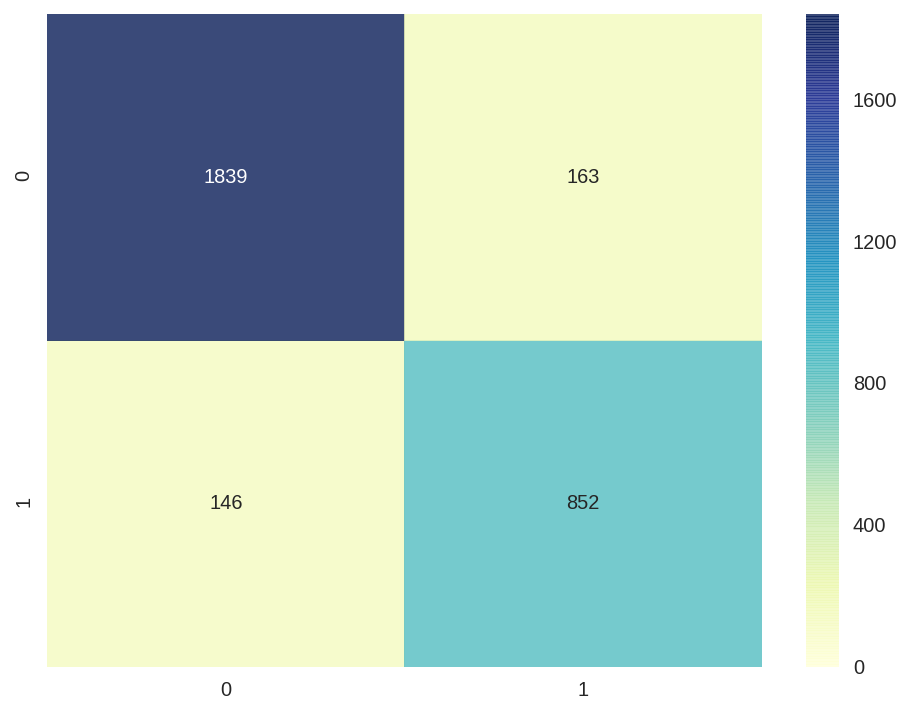

In [56]:
y_pred_3 = model_3.predict_classes(X_test,verbose=0)
y_test_class_3 = np.argmax(Y_test,axis=1)
print(classification_report(y_test_class_3,y_pred_3))
plot_confusion_matrix(model_3,X_test,y_test_class_3)

In [57]:
train_loss_3, train_accuracy_3 = model_3.evaluate(X_train, Y_train, verbose=0)
print("Training Accuracy = %.2f %%     loss = %f" % (train_accuracy_3 * 100, train_loss_3))
test_loss_3, test_accuracy_3 = model_3.evaluate(X_test, Y_test, verbose=0)
print("Testing Accuracy = %.2f %%    loss = %f" % (test_accuracy_3 * 100, test_loss_3))

Training Accuracy = 90.31 %     loss = 0.433246
Testing Accuracy = 89.70 %    loss = 0.442119


### 1.4 Neural Network with L2 Regularization $\lambda=0.001$


In [58]:
regu_4 = regularizers.l2(l=0.001)
model_4 = model(regu_4)
model_4.history = model_4.fit(X_train,Y_train,
                              epochs=epochs,
                              batch_size=batch_size,
                              validation_data=(X_test,Y_test),verbose=2)

Train on 12000 samples, validate on 3000 samples
Epoch 1/200
 - 1s - loss: 0.7232 - acc: 0.7122 - val_loss: 0.6230 - val_acc: 0.7720
Epoch 2/200
 - 0s - loss: 0.5720 - acc: 0.7972 - val_loss: 0.5355 - val_acc: 0.8180
Epoch 3/200
 - 0s - loss: 0.5251 - acc: 0.8133 - val_loss: 0.5040 - val_acc: 0.8290
Epoch 4/200
 - 0s - loss: 0.4980 - acc: 0.8246 - val_loss: 0.4857 - val_acc: 0.8293
Epoch 5/200
 - 0s - loss: 0.4792 - acc: 0.8313 - val_loss: 0.4687 - val_acc: 0.8333
Epoch 6/200
 - 0s - loss: 0.4611 - acc: 0.8385 - val_loss: 0.4668 - val_acc: 0.8373
Epoch 7/200
 - 0s - loss: 0.4465 - acc: 0.8441 - val_loss: 0.4575 - val_acc: 0.8437
Epoch 8/200
 - 0s - loss: 0.4361 - acc: 0.8503 - val_loss: 0.4340 - val_acc: 0.8553
Epoch 9/200
 - 0s - loss: 0.4296 - acc: 0.8538 - val_loss: 0.4261 - val_acc: 0.8587
Epoch 10/200
 - 0s - loss: 0.4186 - acc: 0.8562 - val_loss: 0.4273 - val_acc: 0.8517
Epoch 11/200
 - 0s - loss: 0.4067 - acc: 0.8611 - val_loss: 0.4208 - val_acc: 0.8567
Epoch 12/200
 - 0s - loss

 - 0s - loss: 0.2799 - acc: 0.9163 - val_loss: 0.3158 - val_acc: 0.8990
Epoch 35/200
 - 0s - loss: 0.2842 - acc: 0.9114 - val_loss: 0.3146 - val_acc: 0.8973
Epoch 36/200
 - 0s - loss: 0.2769 - acc: 0.9163 - val_loss: 0.3111 - val_acc: 0.8980
Epoch 37/200
 - 0s - loss: 0.2751 - acc: 0.9152 - val_loss: 0.3085 - val_acc: 0.9000
Epoch 38/200
 - 0s - loss: 0.2728 - acc: 0.9158 - val_loss: 0.3106 - val_acc: 0.8987
Epoch 39/200
 - 0s - loss: 0.2723 - acc: 0.9173 - val_loss: 0.3075 - val_acc: 0.9007
Epoch 40/200
 - 0s - loss: 0.2696 - acc: 0.9176 - val_loss: 0.3084 - val_acc: 0.8990
Epoch 41/200
 - 0s - loss: 0.2683 - acc: 0.9191 - val_loss: 0.3043 - val_acc: 0.9007
Epoch 42/200
 - 0s - loss: 0.2657 - acc: 0.9182 - val_loss: 0.3091 - val_acc: 0.9003
Epoch 43/200
 - 0s - loss: 0.2659 - acc: 0.9185 - val_loss: 0.3106 - val_acc: 0.8983
Epoch 44/200
 - 0s - loss: 0.2644 - acc: 0.9185 - val_loss: 0.3041 - val_acc: 0.9003
Epoch 45/200
 - 0s - loss: 0.2640 - acc: 0.9196 - val_loss: 0.3063 - val_acc: 

Epoch 68/200
 - 0s - loss: 0.2453 - acc: 0.9254 - val_loss: 0.3009 - val_acc: 0.9050
Epoch 69/200
 - 0s - loss: 0.2505 - acc: 0.9230 - val_loss: 0.2931 - val_acc: 0.9040
Epoch 70/200
 - 0s - loss: 0.2420 - acc: 0.9257 - val_loss: 0.2890 - val_acc: 0.9063
Epoch 71/200
 - 0s - loss: 0.2429 - acc: 0.9258 - val_loss: 0.2963 - val_acc: 0.9030
Epoch 72/200
 - 0s - loss: 0.2471 - acc: 0.9236 - val_loss: 0.3019 - val_acc: 0.8973
Epoch 73/200
 - 0s - loss: 0.2483 - acc: 0.9242 - val_loss: 0.2974 - val_acc: 0.9023
Epoch 74/200
 - 0s - loss: 0.2408 - acc: 0.9279 - val_loss: 0.2897 - val_acc: 0.9050
Epoch 75/200
 - 0s - loss: 0.2400 - acc: 0.9285 - val_loss: 0.2936 - val_acc: 0.9047
Epoch 76/200
 - 0s - loss: 0.2428 - acc: 0.9253 - val_loss: 0.2853 - val_acc: 0.9093
Epoch 77/200
 - 0s - loss: 0.2412 - acc: 0.9245 - val_loss: 0.2900 - val_acc: 0.9063
Epoch 78/200
 - 0s - loss: 0.2391 - acc: 0.9288 - val_loss: 0.2914 - val_acc: 0.9053
Epoch 79/200
 - 0s - loss: 0.2409 - acc: 0.9278 - val_loss: 0.303

Epoch 102/200
 - 0s - loss: 0.2329 - acc: 0.9289 - val_loss: 0.3030 - val_acc: 0.8980
Epoch 103/200
 - 0s - loss: 0.2321 - acc: 0.9288 - val_loss: 0.2959 - val_acc: 0.9040
Epoch 104/200
 - 0s - loss: 0.2369 - acc: 0.9288 - val_loss: 0.2875 - val_acc: 0.9067
Epoch 105/200
 - 0s - loss: 0.2297 - acc: 0.9301 - val_loss: 0.2882 - val_acc: 0.9037
Epoch 106/200
 - 0s - loss: 0.2314 - acc: 0.9313 - val_loss: 0.2867 - val_acc: 0.9087
Epoch 107/200
 - 0s - loss: 0.2304 - acc: 0.9309 - val_loss: 0.2900 - val_acc: 0.9043
Epoch 108/200
 - 0s - loss: 0.2290 - acc: 0.9318 - val_loss: 0.2895 - val_acc: 0.9067
Epoch 109/200
 - 0s - loss: 0.2310 - acc: 0.9283 - val_loss: 0.2887 - val_acc: 0.9097
Epoch 110/200
 - 0s - loss: 0.2275 - acc: 0.9339 - val_loss: 0.2885 - val_acc: 0.9040
Epoch 111/200
 - 0s - loss: 0.2277 - acc: 0.9327 - val_loss: 0.2984 - val_acc: 0.9033
Epoch 112/200
 - 0s - loss: 0.2301 - acc: 0.9309 - val_loss: 0.2912 - val_acc: 0.9023
Epoch 113/200
 - 0s - loss: 0.2272 - acc: 0.9358 - val

Epoch 136/200
 - 0s - loss: 0.2199 - acc: 0.9359 - val_loss: 0.2928 - val_acc: 0.9043
Epoch 137/200
 - 0s - loss: 0.2227 - acc: 0.9343 - val_loss: 0.2963 - val_acc: 0.9063
Epoch 138/200
 - 0s - loss: 0.2266 - acc: 0.9313 - val_loss: 0.2869 - val_acc: 0.9117
Epoch 139/200
 - 0s - loss: 0.2226 - acc: 0.9346 - val_loss: 0.2912 - val_acc: 0.9060
Epoch 140/200
 - 0s - loss: 0.2226 - acc: 0.9333 - val_loss: 0.2922 - val_acc: 0.9043
Epoch 141/200
 - 0s - loss: 0.2242 - acc: 0.9329 - val_loss: 0.2843 - val_acc: 0.9103
Epoch 142/200
 - 0s - loss: 0.2243 - acc: 0.9337 - val_loss: 0.2876 - val_acc: 0.9077
Epoch 143/200
 - 0s - loss: 0.2210 - acc: 0.9334 - val_loss: 0.3033 - val_acc: 0.8977
Epoch 144/200
 - 0s - loss: 0.2189 - acc: 0.9366 - val_loss: 0.2882 - val_acc: 0.9077
Epoch 145/200
 - 0s - loss: 0.2188 - acc: 0.9359 - val_loss: 0.2902 - val_acc: 0.9090
Epoch 146/200
 - 0s - loss: 0.2197 - acc: 0.9373 - val_loss: 0.2981 - val_acc: 0.9030
Epoch 147/200
 - 0s - loss: 0.2210 - acc: 0.9347 - val

Epoch 170/200
 - 0s - loss: 0.2150 - acc: 0.9381 - val_loss: 0.2869 - val_acc: 0.9093
Epoch 171/200
 - 0s - loss: 0.2138 - acc: 0.9377 - val_loss: 0.2891 - val_acc: 0.9113
Epoch 172/200
 - 0s - loss: 0.2158 - acc: 0.9362 - val_loss: 0.3218 - val_acc: 0.8903
Epoch 173/200
 - 0s - loss: 0.2113 - acc: 0.9395 - val_loss: 0.2948 - val_acc: 0.9027
Epoch 174/200
 - 0s - loss: 0.2175 - acc: 0.9375 - val_loss: 0.3009 - val_acc: 0.9057
Epoch 175/200
 - 0s - loss: 0.2104 - acc: 0.9411 - val_loss: 0.2931 - val_acc: 0.9063
Epoch 176/200
 - 0s - loss: 0.2148 - acc: 0.9376 - val_loss: 0.2909 - val_acc: 0.9063
Epoch 177/200
 - 0s - loss: 0.2127 - acc: 0.9384 - val_loss: 0.2963 - val_acc: 0.9050
Epoch 178/200
 - 0s - loss: 0.2120 - acc: 0.9374 - val_loss: 0.2842 - val_acc: 0.9110
Epoch 179/200
 - 0s - loss: 0.2162 - acc: 0.9351 - val_loss: 0.3015 - val_acc: 0.9013
Epoch 180/200
 - 0s - loss: 0.2101 - acc: 0.9410 - val_loss: 0.2881 - val_acc: 0.9073
Epoch 181/200
 - 0s - loss: 0.2121 - acc: 0.9406 - val

             precision    recall  f1-score   support

          0       0.91      0.96      0.93      2002
          1       0.90      0.82      0.86       998

avg / total       0.91      0.91      0.91      3000



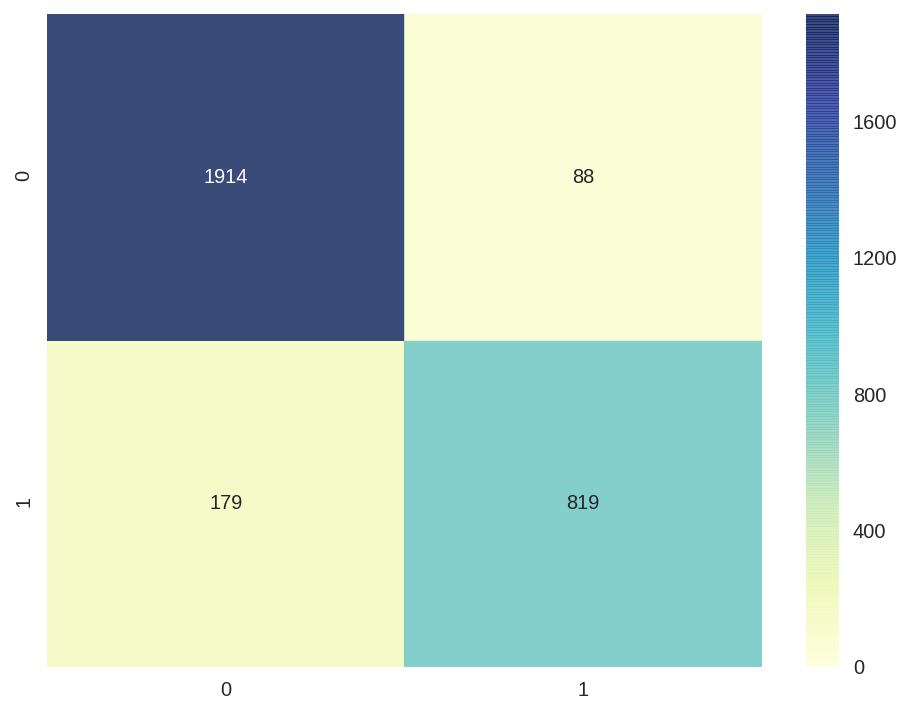

In [59]:
y_pred_4 = model_4.predict_classes(X_test,verbose=0)
y_test_class_4 = np.argmax(Y_test,axis=1)
print(classification_report(y_test_class_4,y_pred_4))
plot_confusion_matrix(model_4,X_test,y_test_class_4)

In [60]:
train_loss_4, train_accuracy_4 = model_4.evaluate(X_train, Y_train, verbose=0)
print("Training Accuracy = %.2f %%     loss = %f" % (train_accuracy_4 * 100, train_loss_4))
test_loss_4, test_accuracy_4 = model_4.evaluate(X_test, Y_test, verbose=0)
print("Testing Accuracy = %.2f %%    loss = %f" % (test_accuracy_4 * 100, test_loss_4))

Training Accuracy = 94.27 %     loss = 0.204765
Testing Accuracy = 91.10 %    loss = 0.296099


### 1.5 Neural Network with L2 Regularization $\lambda=0.0001$

In [61]:
regu_5 = regularizers.l2(l=0.0001)
model_5 = model(regu_5)
model_5.history = model_5.fit(X_train,Y_train,
                              epochs=epochs,
                              batch_size=batch_size,
                              validation_data=(X_test,Y_test),verbose=2)

Train on 12000 samples, validate on 3000 samples
Epoch 1/200
 - 1s - loss: 0.5775 - acc: 0.7075 - val_loss: 0.4861 - val_acc: 0.7733
Epoch 2/200
 - 0s - loss: 0.4468 - acc: 0.8011 - val_loss: 0.4128 - val_acc: 0.8217
Epoch 3/200
 - 0s - loss: 0.4041 - acc: 0.8229 - val_loss: 0.3959 - val_acc: 0.8287
Epoch 4/200
 - 0s - loss: 0.3864 - acc: 0.8337 - val_loss: 0.3846 - val_acc: 0.8367
Epoch 5/200
 - 0s - loss: 0.3747 - acc: 0.8418 - val_loss: 0.3719 - val_acc: 0.8417
Epoch 6/200
 - 0s - loss: 0.3655 - acc: 0.8442 - val_loss: 0.3668 - val_acc: 0.8490
Epoch 7/200
 - 0s - loss: 0.3567 - acc: 0.8509 - val_loss: 0.3665 - val_acc: 0.8503
Epoch 8/200
 - 0s - loss: 0.3459 - acc: 0.8551 - val_loss: 0.3543 - val_acc: 0.8540
Epoch 9/200
 - 0s - loss: 0.3350 - acc: 0.8627 - val_loss: 0.3517 - val_acc: 0.8573
Epoch 10/200
 - 0s - loss: 0.3310 - acc: 0.8663 - val_loss: 0.3391 - val_acc: 0.8600
Epoch 11/200
 - 0s - loss: 0.3184 - acc: 0.8708 - val_loss: 0.3369 - val_acc: 0.8647
Epoch 12/200
 - 0s - loss

 - 0s - loss: 0.2093 - acc: 0.9219 - val_loss: 0.2775 - val_acc: 0.8910
Epoch 35/200
 - 0s - loss: 0.2107 - acc: 0.9218 - val_loss: 0.2708 - val_acc: 0.8937
Epoch 36/200
 - 0s - loss: 0.2044 - acc: 0.9232 - val_loss: 0.2759 - val_acc: 0.8947
Epoch 37/200
 - 0s - loss: 0.2032 - acc: 0.9255 - val_loss: 0.2712 - val_acc: 0.8883
Epoch 38/200
 - 0s - loss: 0.1993 - acc: 0.9241 - val_loss: 0.2689 - val_acc: 0.8910
Epoch 39/200
 - 0s - loss: 0.2006 - acc: 0.9257 - val_loss: 0.2742 - val_acc: 0.8903
Epoch 40/200
 - 0s - loss: 0.2000 - acc: 0.9253 - val_loss: 0.2872 - val_acc: 0.8887
Epoch 41/200
 - 0s - loss: 0.1995 - acc: 0.9240 - val_loss: 0.2797 - val_acc: 0.8913
Epoch 42/200
 - 0s - loss: 0.2002 - acc: 0.9264 - val_loss: 0.2778 - val_acc: 0.8920
Epoch 43/200
 - 0s - loss: 0.2012 - acc: 0.9243 - val_loss: 0.2871 - val_acc: 0.8903
Epoch 44/200
 - 0s - loss: 0.2010 - acc: 0.9240 - val_loss: 0.2746 - val_acc: 0.8983
Epoch 45/200
 - 0s - loss: 0.1946 - acc: 0.9282 - val_loss: 0.2728 - val_acc: 

Epoch 68/200
 - 0s - loss: 0.1754 - acc: 0.9366 - val_loss: 0.2823 - val_acc: 0.8930
Epoch 69/200
 - 0s - loss: 0.1716 - acc: 0.9392 - val_loss: 0.2824 - val_acc: 0.8957
Epoch 70/200
 - 0s - loss: 0.1746 - acc: 0.9375 - val_loss: 0.2766 - val_acc: 0.8967
Epoch 71/200
 - 0s - loss: 0.1707 - acc: 0.9377 - val_loss: 0.2848 - val_acc: 0.8917
Epoch 72/200
 - 0s - loss: 0.1711 - acc: 0.9372 - val_loss: 0.2810 - val_acc: 0.8983
Epoch 73/200
 - 0s - loss: 0.1747 - acc: 0.9348 - val_loss: 0.2968 - val_acc: 0.8903
Epoch 74/200
 - 0s - loss: 0.1769 - acc: 0.9341 - val_loss: 0.2962 - val_acc: 0.8873
Epoch 75/200
 - 0s - loss: 0.1761 - acc: 0.9360 - val_loss: 0.2785 - val_acc: 0.8967
Epoch 76/200
 - 0s - loss: 0.1699 - acc: 0.9376 - val_loss: 0.2936 - val_acc: 0.8900
Epoch 77/200
 - 0s - loss: 0.1696 - acc: 0.9377 - val_loss: 0.2926 - val_acc: 0.8923
Epoch 78/200
 - 0s - loss: 0.1661 - acc: 0.9414 - val_loss: 0.2817 - val_acc: 0.8967
Epoch 79/200
 - 0s - loss: 0.1663 - acc: 0.9396 - val_loss: 0.332

Epoch 102/200
 - 0s - loss: 0.1533 - acc: 0.9464 - val_loss: 0.3029 - val_acc: 0.8930
Epoch 103/200
 - 0s - loss: 0.1519 - acc: 0.9453 - val_loss: 0.3194 - val_acc: 0.8927
Epoch 104/200
 - 0s - loss: 0.1532 - acc: 0.9453 - val_loss: 0.3194 - val_acc: 0.8900
Epoch 105/200
 - 0s - loss: 0.1503 - acc: 0.9479 - val_loss: 0.3025 - val_acc: 0.8927
Epoch 106/200
 - 0s - loss: 0.1489 - acc: 0.9487 - val_loss: 0.3060 - val_acc: 0.8887
Epoch 107/200
 - 0s - loss: 0.1470 - acc: 0.9514 - val_loss: 0.3039 - val_acc: 0.8980
Epoch 108/200
 - 0s - loss: 0.1538 - acc: 0.9459 - val_loss: 0.3069 - val_acc: 0.8887
Epoch 109/200
 - 0s - loss: 0.1535 - acc: 0.9454 - val_loss: 0.3249 - val_acc: 0.8897
Epoch 110/200
 - 0s - loss: 0.1502 - acc: 0.9457 - val_loss: 0.3242 - val_acc: 0.8873
Epoch 111/200
 - 0s - loss: 0.1594 - acc: 0.9413 - val_loss: 0.2974 - val_acc: 0.8933
Epoch 112/200
 - 0s - loss: 0.1471 - acc: 0.9494 - val_loss: 0.3014 - val_acc: 0.8943
Epoch 113/200
 - 0s - loss: 0.1430 - acc: 0.9508 - val

Epoch 136/200
 - 0s - loss: 0.1333 - acc: 0.9565 - val_loss: 0.3241 - val_acc: 0.8957
Epoch 137/200
 - 0s - loss: 0.1349 - acc: 0.9542 - val_loss: 0.3323 - val_acc: 0.8907
Epoch 138/200
 - 0s - loss: 0.1353 - acc: 0.9534 - val_loss: 0.3452 - val_acc: 0.8920
Epoch 139/200
 - 0s - loss: 0.1326 - acc: 0.9537 - val_loss: 0.3464 - val_acc: 0.8900
Epoch 140/200
 - 0s - loss: 0.1302 - acc: 0.9568 - val_loss: 0.3350 - val_acc: 0.8950
Epoch 141/200
 - 0s - loss: 0.1318 - acc: 0.9568 - val_loss: 0.3437 - val_acc: 0.8957
Epoch 142/200
 - 0s - loss: 0.1278 - acc: 0.9581 - val_loss: 0.3327 - val_acc: 0.8923
Epoch 143/200
 - 0s - loss: 0.1258 - acc: 0.9598 - val_loss: 0.3412 - val_acc: 0.8923
Epoch 144/200
 - 0s - loss: 0.1292 - acc: 0.9566 - val_loss: 0.3438 - val_acc: 0.8957
Epoch 145/200
 - 0s - loss: 0.1287 - acc: 0.9580 - val_loss: 0.3392 - val_acc: 0.8900
Epoch 146/200
 - 0s - loss: 0.1310 - acc: 0.9578 - val_loss: 0.3643 - val_acc: 0.8887
Epoch 147/200
 - 0s - loss: 0.1301 - acc: 0.9569 - val

Epoch 170/200
 - 0s - loss: 0.1152 - acc: 0.9627 - val_loss: 0.3701 - val_acc: 0.8920
Epoch 171/200
 - 0s - loss: 0.1155 - acc: 0.9610 - val_loss: 0.3653 - val_acc: 0.8930
Epoch 172/200
 - 0s - loss: 0.1081 - acc: 0.9683 - val_loss: 0.3906 - val_acc: 0.8900
Epoch 173/200
 - 0s - loss: 0.1094 - acc: 0.9680 - val_loss: 0.3704 - val_acc: 0.8913
Epoch 174/200
 - 0s - loss: 0.1169 - acc: 0.9608 - val_loss: 0.3940 - val_acc: 0.8860
Epoch 175/200
 - 0s - loss: 0.1106 - acc: 0.9655 - val_loss: 0.3700 - val_acc: 0.8937
Epoch 176/200
 - 0s - loss: 0.1117 - acc: 0.9659 - val_loss: 0.4051 - val_acc: 0.8927
Epoch 177/200
 - 0s - loss: 0.1145 - acc: 0.9628 - val_loss: 0.3901 - val_acc: 0.8937
Epoch 178/200
 - 0s - loss: 0.1061 - acc: 0.9674 - val_loss: 0.3926 - val_acc: 0.8920
Epoch 179/200
 - 0s - loss: 0.1110 - acc: 0.9642 - val_loss: 0.3987 - val_acc: 0.8887
Epoch 180/200
 - 0s - loss: 0.1090 - acc: 0.9654 - val_loss: 0.3874 - val_acc: 0.8903
Epoch 181/200
 - 0s - loss: 0.1045 - acc: 0.9687 - val

             precision    recall  f1-score   support

          0       0.92      0.90      0.91      2002
          1       0.81      0.85      0.83       998

avg / total       0.89      0.88      0.88      3000



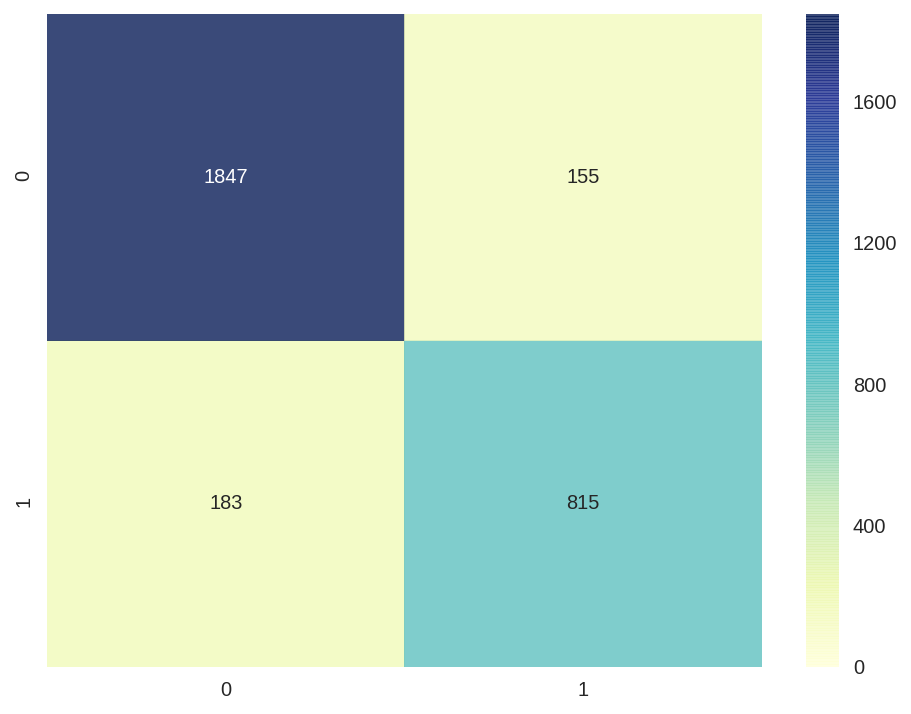

In [62]:
y_pred_5 = model_1.predict_classes(X_test,verbose=0)
y_test_class_5 = np.argmax(Y_test,axis=1)
print(classification_report(y_test_class_5,y_pred_5))
plot_confusion_matrix(model_5,X_test,y_test_class_5)

In [63]:
train_loss_5, train_accuracy_5 = model_5.evaluate(X_train, Y_train, verbose=0)
print("Training Accuracy = %.2f %%     loss = %f" % (train_accuracy_5 * 100, train_loss_5))
test_loss_5, test_accuracy_5 = model_5.evaluate(X_test, Y_test, verbose=0)
print("Testing Accuracy = %.2f %%    loss = %f" % (test_accuracy_5 * 100, test_loss_5))

Training Accuracy = 97.20 %     loss = 0.093806
Testing Accuracy = 88.73 %    loss = 0.415487


## Plot Training and Testing Accuracy and Loss 

In [0]:
colors = sns.color_palette("husl", 8)
import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 2

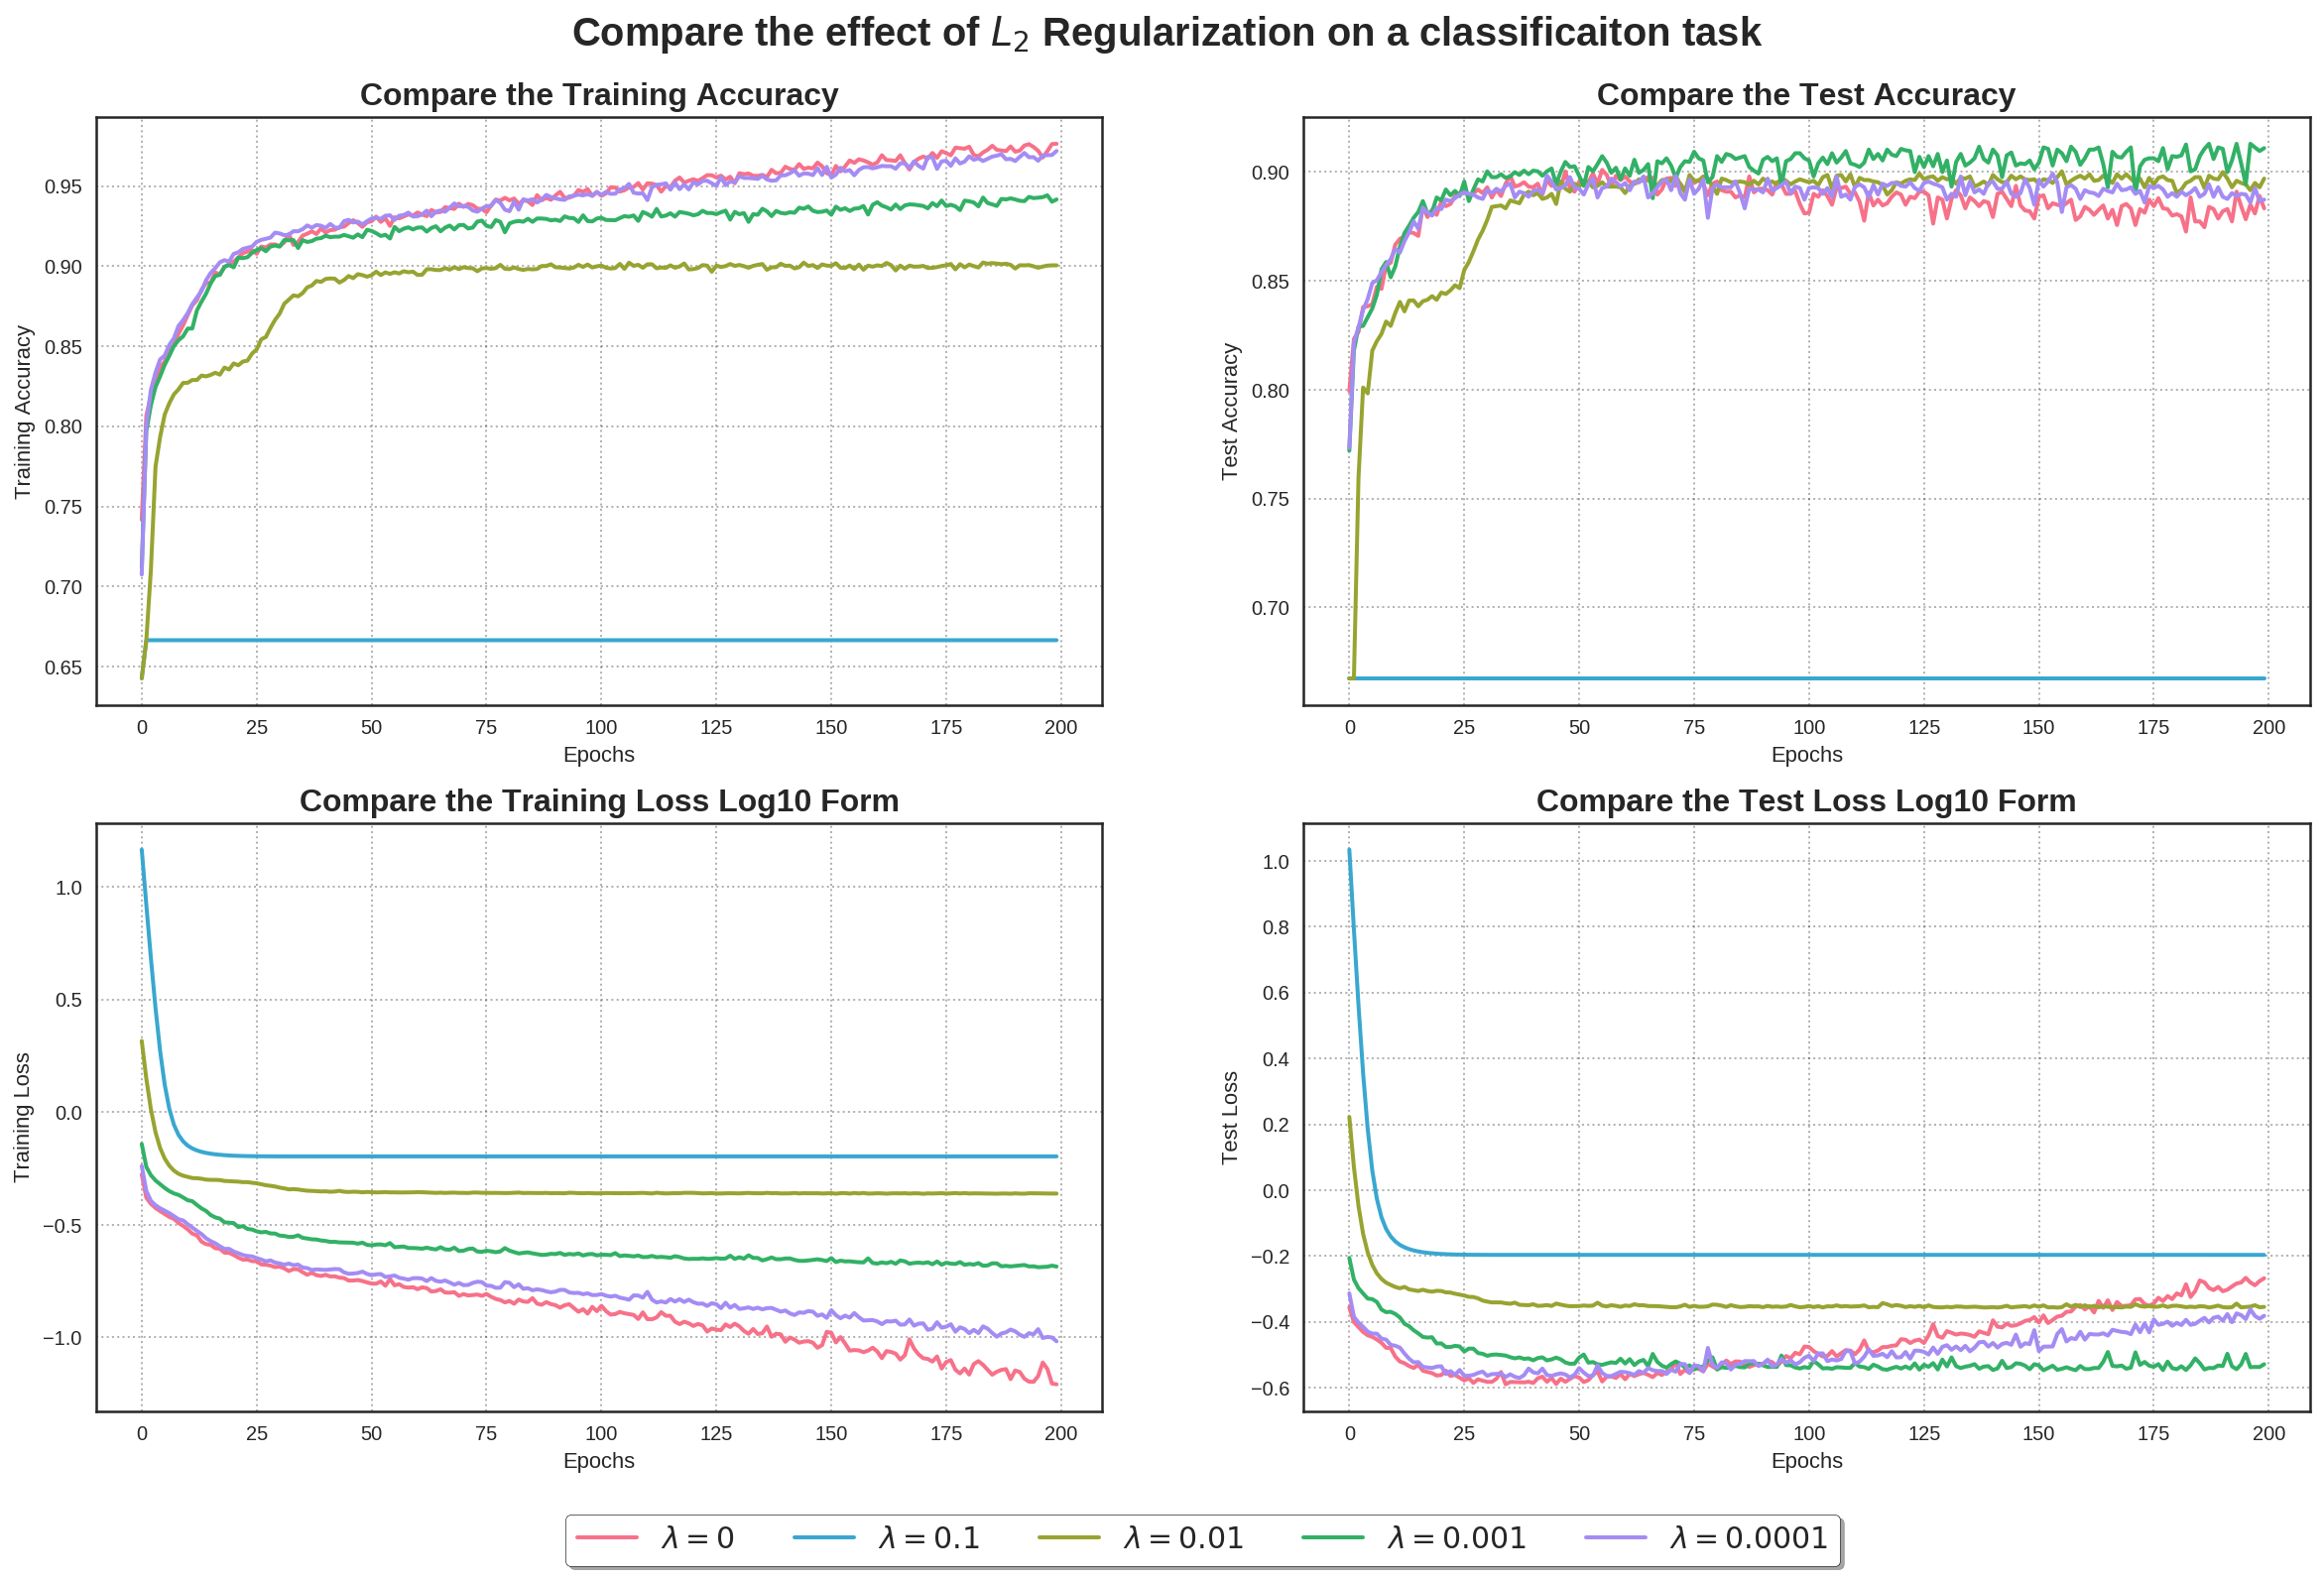

In [65]:
plt.style.use('seaborn-white')
fig,((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(20,12))
ax1.plot(model_1.history.history['acc'],color=colors[0],label='$\lambda=0$')
ax1.plot(model_2.history.history['acc'],color=colors[5],label='$\lambda=0.1$')
ax1.plot(model_3.history.history['acc'],color=colors[2],label='$\lambda=0.01$')
ax1.plot(model_4.history.history['acc'],color=colors[3],label='$\lambda=0.001$')
ax1.plot(model_5.history.history['acc'],color=colors[6],label='$\lambda=0.0001$')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Training Accuracy')
ax1.grid(True,color='black',linestyle='dotted',linewidth=1,alpha=.3)
ax1.set_title('Compare the Training Accuracy',fontsize=16, fontweight='bold')


ax2.plot(model_1.history.history['val_acc'],color=colors[0],label='$\lambda=0$')
ax2.plot(model_2.history.history['val_acc'],color=colors[5],label='$\lambda=0.1$')
ax2.plot(model_3.history.history['val_acc'],color=colors[2],label='$\lambda=0.01$')
ax2.plot(model_4.history.history['val_acc'],color=colors[3],label='$\lambda=0.001$')
ax2.plot(model_5.history.history['val_acc'],color=colors[6],label='$\lambda=0.0001$')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Test Accuracy')
ax2.grid(True,color='black',linestyle='dotted',linewidth=1,alpha=.3)
ax2.set_title('Compare the Test Accuracy',fontsize=16, fontweight='bold')


ax3.plot(np.log10(model_1.history.history['loss']),color=colors[0],label='$\lambda=0$')
ax3.plot(np.log10(model_2.history.history['loss']),color=colors[5],label='$\lambda=0.1$')
ax3.plot(np.log10(model_3.history.history['loss']),color=colors[2],label='$\lambda=0.01$')
ax3.plot(np.log10(model_4.history.history['loss']),color=colors[3],label='$\lambda=0.001$')
ax3.plot(np.log10(model_5.history.history['loss']),color=colors[6],label='$\lambda=0.0001$')
ax3.set_xlabel('Epochs')
ax3.set_ylabel('Training Loss')
ax3.grid(True,color='black',linestyle='dotted',linewidth=1,alpha=.3)
ax3.set_title('Compare the Training Loss Log10 Form',fontsize=16, fontweight='bold')


ax4.plot(np.log10(model_1.history.history['val_loss']),color=colors[0],label='$\lambda=0$')
ax4.plot(np.log10(model_2.history.history['val_loss']),color=colors[5],label='$\lambda=0.1$')
ax4.plot(np.log10(model_3.history.history['val_loss']),color=colors[2],label='$\lambda=0.01$')
ax4.plot(np.log10(model_4.history.history['val_loss']),color=colors[3],label='$\lambda=0.001$')
ax4.plot(np.log10(model_5.history.history['val_loss']),color=colors[6],label='$\lambda=0.0001$')
ax4.set_xlabel('Epochs')
ax4.set_ylabel('Test Loss')
ax4.grid(True,color='black',linestyle='dotted',linewidth=1,alpha=.3)
ax4.set_title('Compare the Test Loss Log10 Form',fontsize=16, fontweight='bold')

plt.legend(loc='upper center', bbox_to_anchor=(-0.1, -0.15),
          ncol=5, fancybox=True, shadow=True, frameon=True,edgecolor='black',fontsize=15)

fig.suptitle('Compare the effect of $L_2$ Regularization on a classificaiton task',fontsize=20, fontweight='bold',y=0.94)
plt.show()